# OSDR One-Shot Dynamics (Local Copy)

This notebook is copied from `osdr/docs/tutorials/one-shot-dynamics-in-7-minutes.ipynb` and set to use the **Python (osdr)** kernel.
It downloads example data and may take several minutes to run.


# One-Shot Dynamics in 7 Minutes

## Welcome!

This tutorial will take you through a complete *One-Shot Tissue Dynamics Reconstruction* (OSDR) workflow by reproducing figure 3 from [Somer et. al 2024](https://www.biorxiv.org/content/10.1101/2024.04.22.590503v1). We will download a dataset, estimate a dynamical model and plot a 2D phase-portrait of fibroblast-macropahge dynamics. 

Before we begin, let's download the dataset we'll use throughout the tutorial by running the following code block. 

This could take a few minutes the first time so continue reading while the data is downloading.

We'll work with the breast cancer IMC dataset by [Danenberg et. al 2022](https://www.nature.com/articles/s41588-022-01041-y). 
This dataset includes 793 spatial proteomics tissue sections from 717 breast cancer patients, totalling ~864K cells.

Fibroblast-macrophage dynamics in breast cancer serve as a useful test-case for our model because [Mayer et. al 2023](https://www.nature.com/articles/s41467-023-41518-w) experimentally discovered the dynamics between these two cell types.

In [ ]:
# Robust dataset download + writable data dir
from pathlib import Path
import zipfile
import requests
from tdm.raw import breast_mibi

# Store data in a local, writable folder
LOCAL_DATA_DIR = Path.cwd() / 'osdr_data'
breast_mibi.DATA_DIR = LOCAL_DATA_DIR
breast_mibi.BREAST_MIBI_DATA_DIR = LOCAL_DATA_DIR / 'breast_mibi'
breast_mibi.BREAST_MIBI_ZIP_PATH = breast_mibi.BREAST_MIBI_DATA_DIR / 'breast_mibi.zip'
breast_mibi.BREAST_UNZIPPED_DIR = breast_mibi.BREAST_MIBI_DATA_DIR / 'MBTMEIMCPublic'
breast_mibi.SINGLE_CELL_TABLE_PATH = breast_mibi.BREAST_MIBI_DATA_DIR / breast_mibi.SINGLE_CELL_TABLE_NAME
breast_mibi.SINGLE_CELL_TABLE_PATH_IN_UNZIPPED_DIR = breast_mibi.BREAST_UNZIPPED_DIR / breast_mibi.SINGLE_CELL_TABLE_NAME
breast_mibi.CLINICAL_TABLE_PATH = breast_mibi.BREAST_MIBI_DATA_DIR / breast_mibi.CLINICAL_TABLE_NAME

def _download_zip(url: str, dest: Path) -> None:
    resp = requests.get(url, stream=True)
    resp.raise_for_status()
    dest.parent.mkdir(parents=True, exist_ok=True)
    with open(dest, 'wb') as f:
        for chunk in resp.iter_content(chunk_size=1024 * 1024):
            if chunk:
                f.write(chunk)

# Try a couple of known Zenodo URL formats
candidate_urls = [
    breast_mibi.BREAST_MIBI_DOWNLOAD_URL,
    'https://zenodo.org/records/7324285/files/MBTMEStrPublicProcessedDataCode.zip?download=1',
]

zip_path = breast_mibi.BREAST_MIBI_ZIP_PATH
if zip_path.exists() and not zipfile.is_zipfile(zip_path):
    zip_path.unlink()

if not zip_path.exists():
    last_error = None
    for url in candidate_urls:
        try:
            _download_zip(url, zip_path)
            if zipfile.is_zipfile(zip_path):
                last_error = None
                break
            zip_path.unlink(missing_ok=True)
        except Exception as e:
            last_error = e
            if zip_path.exists():
                zip_path.unlink()
    if last_error is not None:
        raise last_error

assert zipfile.is_zipfile(zip_path), f'Not a zip file: {zip_path}'


In [9]:
from tdm.raw.breast_mibi import read_single_cell_df

single_cell_df = read_single_cell_df()

In [10]:
single_cell_df.shape

(859710, 61)

## Overview of OSDR

OSDR uses statistical models to learn how the composition of a cell's neighborhood influences it's division rate.

Thus, the core input to OSDR consists of:

* x,y positions of cells in the tissue
* cell types
* cell division labels (1 = dividing, 0 = not dividing)

For datasets including samples from multiple patients or multiple tissue sections ("images") per patient, we also require:

* subject id
* image id

## The Single-Cell Dataframe

To use OSDR we first prepare one large table with a row for each cell and a column for each parameter above. 

We call this table the "single-cell dataframe".

The module `tdm.preprocess.single_cell_df` contains utilities for preparing and validating the table. 

The raw data we downloaded includes many columns, including levels of various markers:

In [11]:
list(single_cell_df.columns)

['index',
 'ImageNumber',
 'ObjectNumber',
 'metabric_id',
 'cellPhenotype',
 'is_epithelial',
 'is_tumour',
 'is_normal',
 'is_dcis',
 'is_interface',
 'is_perivascular',
 'is_hotAggregate',
 'Histone H3',
 'SMA',
 'CK5',
 'CD38',
 'HLA-DR',
 'CK8-18',
 'CD15',
 'FSP1',
 'CD163',
 'ICOS',
 'OX40',
 'CD68',
 'HER2 (3B5)',
 'CD3',
 'Podoplanin',
 'CD11c',
 'PD-1',
 'GITR',
 'CD16',
 'HER2 (D8F12)',
 'CD45RA',
 'B2M',
 'CD45RO',
 'FOXP3',
 'CD20',
 'ER',
 'CD8',
 'CD57',
 'Ki-67',
 'PDGFRB',
 'Caveolin-1',
 'CD4',
 'CD31-vWF',
 'CXCL12',
 'HLA-ABC',
 'panCK',
 'c-Caspase3',
 'DNA1',
 'DNA2',
 'Location_Center_X',
 'Location_Center_Y',
 'AreaShape_Area',
 'x',
 'y',
 'ki67',
 'cell_type',
 'img_id',
 'subject_id',
 'division']

We can use the function `restrict_df_to_required_columns` to select just the subset of columns OSDR requires. 

A preprocessed table looks like this:

In [12]:
from tdm.preprocess.single_cell_df import restrict_df_to_required_columns

restrict_df_to_required_columns(single_cell_df).head(3)

,x,y,division,cell_type,img_id,subject_id
0,0.000121,0.000004,False,Tu,1,MB-0282
1,0.000222,0.000005,False,T,1,MB-0282
2,0.000354,0.000006,False,Tu,1,MB-0282


There are `x,y` coordinates in meters. For example, the y value of the first cell, `0.000004`, corresponds with 4 microns. 
There is a boolean label for cell division, a string for the cell_type (e.g `Tu` for tumor cells, `T` for T-cells) and unique identifiers for images and subjects.

We can check the dataframe was processed correctly using `check_single_cell_df`.



In [13]:
from tdm.preprocess.single_cell_df import check_single_cell_df

assert check_single_cell_df(single_cell_df)

Validating single cell dataframe...

[SUCCESS] Found x column
[SUCCESS] Found y column
[SUCCESS] Found cell_type column. Number of cell types: 6
	Cell types: ['Tu', 'T', 'En', 'F', 'M', 'B']
[SUCCESS] Found division column. Fraction of dividing cells: 0.016
[SUCCESS] Found img_id column. Number of images found: 791
[SUCCESS] Found subject_id column. Number of subjects found: 715

[SUCCESS] Validation complete!


**Note:** 

In order to apply OSDR to your own dataset the only requirement is preparing a single-cell dataframe with the columns: `x, y, division, cell_type, img_id, subject_id`

## The Analysis Object

The `Analysis` class is the primary entity in the `tdm` package.

To see it in action, we will reproduce the dynamics between fibroblasts and macrophages from the paper by ([Somer et. al 2024](https://www.biorxiv.org/content/10.1101/2024.04.22.590503v1))



In [14]:
from tdm.cell_types import FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL
from tdm.analysis import Analysis

ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=[FIBROBLAST, MACROPHAGE],
    allowed_neighbor_types=[FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL],
    polynomial_dataset_kwargs={"degree":2},
    neighborhood_mode='extrapolate',
)

1/5 Constructing tissues [V]
2/5 Counting cell-neighbors [V]
3/5 Filtering cell-types [V]
4/5 Transforming features [V]
5/5 Fitting a model [V]


The `Analysis` object above counted the neighbors of each cell, transformed features and fit statistical models.

### Analysis Arguments, step by step


The single-cell dataframe we prepared is the primary input to the analysis object:

```python
# Don't run this block:
ana = Analysis(
    single_cell_df=single_cell_df,
    ...
)
```

We also specify the cell types we wish to model:

```python
# Don't run this block:
ana = Analysis(
    ...
    cell_types_to_model=[FIBROBLAST, MACROPHAGE], # F, M
    ...
)
```

Providing `cell_types_to_model=[FIBROBLAST, MACROPHAGE]` implies the following dynamical model:

$$
\frac{dF}{dt} = f(F,M)
$$

$$
\frac{dM}{dt} = m(F,M)
$$

This model neglects other cell types that might possibly influence dynamics, such as adaptive immune cells. 

To simplify dynamics, we only include fibroblasts and macrophages from neighborhoods without adaptive immune cells:

```python
# Don't run this block:
ana = Analysis(
    ...
    allowed_neighbor_types=[FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL], # no T or B cells
    ...
)
```

The OSDR dynamical model is based on statistical models that estimate the proliferation rate of each cell type. 
For example, the dynamics of fibroblasts are given by the following equation:

$$
\frac{dF}{dt} = F\cdot (p_F^+(F,M) - p_F^-(F,M))
$$

Where $p_F^+,p_F^-$ are statistical models that map the density of fibroblasts and macrophages to fibroblast division or death rates. 

By default, $p^+$ is implemented as a logistic-regression model. 

Logistic regression fits a linear model in order to estimate probabilities. The connection between features $x$, parameters $\beta$ and the predicted probability $p$ is:

$$\log( p / (1-p)) = x^T \beta$$

In our case, the features $x$ will be second order interaction terms of fibroblasts and macrophage counts:

$$x^T \beta = \beta_0 + \beta_1 F + \beta_2 M  + \beta_3  F^2 +  \beta_4 FM  + \beta_5  M^2$$

The following arguments produce second order interactions as such:


```python
# Don't run this block:
ana = Analysis(
    ...
    polynomial_dataset_kwargs={"degree":2} # 2 is also the default degree, so this argument isn't required
    ...
)
```


## Plotting a phase-portrait

To plot a phase portrait (or any plot for that matter) we pass the analysis object to the corresponding plotting function:

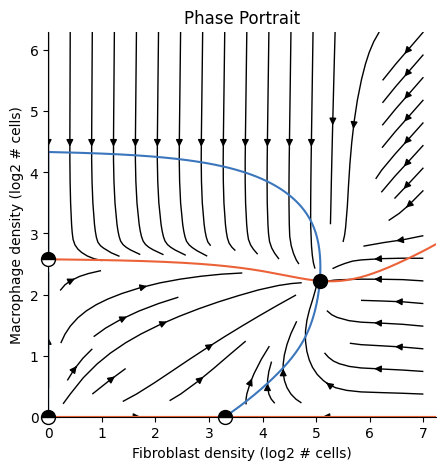

In [15]:
from tdm.plot.two_cells.phase_portrait import plot_phase_portrait
import matplotlib.pyplot as plt

plot_phase_portrait(ana)
plt.show() # required for rendering from terminal

## Tip: Cache the analysis for faster loading

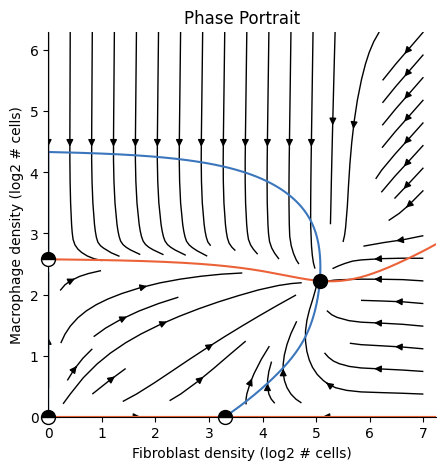

In [16]:
ana.dump('fm.pkl') # caches the analysis
loaded_ana = Analysis.load('fm.pkl') # loads the cached analysis
plot_phase_portrait(loaded_ana)
plt.show() # required for rendering from terminal

## Summary:

Overall, the complete OSDR workflow amounts to: 

1. preparing a single-cell table with columns `x, y, division, cell_type, img_id, subject_id`
2. fitting an `Analysis` object
3. passing the analysis object to a plotting function


The 3 stages are summed up in the following code block:

```python
from tdm.raw.breast_mibi import read_single_cell_df
from tdm.cell_types import FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL
from tdm.analysis import Analysis
from tdm.plot.two_cells.phase_portrait import plot_phase_portrait
import matplotlib.pyplot as plt

# 1. 
single_cell_df = read_single_cell_df()

# 2. 
ana = Analysis(
    single_cell_df=single_cell_df,
    cell_types_to_model=[FIBROBLAST, MACROPHAGE],
    allowed_neighbor_types=[FIBROBLAST, MACROPHAGE, TUMOR, ENDOTHELIAL],
    polynomial_dataset_kwargs={"degree":2},
    neighborhood_mode='extrapolate',
)

# 3. 
plot_phase_portrait(ana)
plt.show() # required for rendering from terminal
```


Some final technical notes:

1. In practice, because quality death markers are lacking, we estimate death rate as a constant based on the mean division rate, see the paper by [Somer et. al 2024](https://www.biorxiv.org/content/10.1101/2024.04.22.590503v1).
2. To increase sample size, we perform the following trick: instead of excluding cells whose neighborhoods intersect tissue limits, we `'extrapolate'` their neighborhood by scaling values according to the fraction of the neighborhood that's observed. For example, if a cell has one macrophage neighbor, and we see just half of the cell's neighborhood, we'll scale the macrophage count by 2.
3. In some cases, we find that the dynamics estimated as $\frac{dX}{dt} = \frac{\text{divisions}}{dt} - \frac{\text{deaths}}{dt}$ produce a net growth of a cell population towards infinite density. We assume there cannot be positive growth at the maximal observed density, and apply the minimal correction required to keep the dynamics confined to the range of observed densities. To apply this correction, add `enforce_max_density=True` and set the power using `max_density_enforcer_power = 8`. For more details on the choice of power see the supplementary in the paper.

